In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from tqdm import tqdm
import glob

In [2]:
# import os
# import yaml
# import glob
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from fastprogress import progress_bar
# import SimpleITK as sitk
# import time
# import nibabel as nib
# from tqdm import tqdm

# import torch 
# from torchvision import transforms as T
# from torch.utils.data import DataLoader, Dataset
# import torch.nn.functional as F
# import monai.transforms

# from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
# from utils.datasets import ImageDataset
# from models.classifier import PLImageClassifier


# class Inference:
#     def __init__(self, cfg, trained_model_path, input_shape=(224, 224), scale_intensity=[0, 1], device='cpu'):
#         self.cfg = cfg
#         self.trained_model_path = trained_model_path
#         self.device = device
#         self.input_shape = input_shape
#         self.labels_dict = [str(i) for i in range(cfg['model_params']['num_labels'])]

#         # Set the augmentation
# #         self.transforms = monai.transforms.Compose(
# #             [
# #                 monai.transforms.Resize(input_shape, size_mode='all'),
# #                 monai.transforms.ToTensor(dtype=torch.float32)
# #             ]
# #         )
#         self.transforms = T.Compose([
#             T.ToPILImage(),
#             T.Resize(self.input_shape),
#             T.ToTensor()
#         ])
#         self.model = self.load_model()


#     def load_model(self):
#         print('Load the trained model in: ', self.trained_model_path)  
#         model = PLImageClassifier(self.cfg)
#         weights = torch.load(self.trained_model_path, map_location='cpu')['state_dict']
#         model.load_state_dict(weights, strict=False)
#         model = model.to(self.device)
#         model.eval()

#         return model

#     def predict(self, img):
#         x = self.transforms(img).unsqueeze(0).to(self.device)
# #         print(x.shape)
#         y = self.model(x)
# #         print(y.shape)
#         y = torch.argmax(y, dim=1).item()
        
#         return y

# def read_config(cfg_path):
#     with open(cfg_path) as file:
#         cfg = yaml.load(file, Loader=yaml.FullLoader)

#     return cfg


In [3]:
# dir_ckpt = 'chromosome_classification-200-20220511-050334'
    
# cfg_path = glob.glob(f'./experiments/{dir_ckpt}/base*.yml')[-1]
# ckpt_path = f'./experiments/{dir_ckpt}/best_model.pth'

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# cfg = read_config(cfg_path)
# cfg['model_params']['pretrained'] = False
# t_params = cfg['train_params']
# # t_params['n_slices'] = cfg['model_params']['in_channels']

# label_list = [str(i) for i in range(cfg['model_params']['num_labels'])]

# model = Inference(cfg, ckpt_path, input_shape=t_params['input_shape'], device=device)
# np.random.seed(0)

  0%|          | 0/121 [00:00<?, ?it/s]

(256, 256, 3)
Done


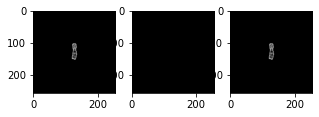

In [13]:
save_folder = 'train_data'
path = './Pussandata/anh phan tich/huuson.tiff/binh thuong'
img_dir = glob.glob(path +'/*.tiff')

# img_dir = glob.glob('./data/test/16/*.jpg')


for img_file in tqdm(img_dir):
    # Step 1: Read image
    img = cv2.imread(img_file)
    fig, ax = plt.subplots(1, 3, figsize=(5, 15))
    ax[0].imshow(img)
    print(img.shape)

    # Step 2: Threshold and find coutour
    h_img, w_img, _ = img.shape

    # Threshold
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # print(gray_img.shape)
    # ax.imshow(gray_img, cmap='gray')
    _, pre_thresh = cv2.threshold(gray_img, 254, 255, cv2.THRESH_BINARY)
    ax[1].imshow(pre_thresh, cmap='gray')
    thresh_img = cv2.morphologyEx(pre_thresh, cv2.MORPH_CLOSE, np.ones(shape=(3, 3), dtype=np.uint8))
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # Use contour to extract sigle chromosome
    cv2.drawContours(img, contours, -1, (255, 0, 0), 2)
    ax[2].imshow(img)

    # Step3: Bounding box
    boxes = [] # Boxes include box for each chromosome, box = [x_center, y_center, w, h]
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        if 10< w < 200 and 10< h < 200 and x > 10 and y > 10: # remove outliers
#             cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 3)

            sub_img = img[y:y+h, x:x+w]
            sub_img = Blackground(sub_img, size=256) # add black background for single chromosome

            sub_img = torch.from_numpy(sub_img)
    #         print(sub_img.shape)
            label = model.predict(sub_img)
            x = (x + w / 2) / w_img
            y = (y + h / 2) / h_img # normalize bbox
            w = w / w_img
            h = h / h_img
            boxes.append([label, x, y, w, h])
    txt_dir = path.replace('anh phan tich', 'bouding box')
    txt_file = txt_dir +'/'+ img_file.split('/')[-1].replace('tiff', 'txt')
    if not os.path.exists(txt_dir):
        os.makedirs(txt_dir, exist_ok=True)
        
    with open(f'{txt_file}', 'w') as file:
        for box in boxes:
            file.write(' '.join([str(s) for s in box]) + '\n')
            
print('Done')
# ax.imshow(img)
#remove ảnh gốc

In [4]:
def Blackground(img, size):  # add single chromosome onto black background
    h, w = img.shape[:2]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    roi = 255 - cv2.inRange(img, 1, 250)  # seperate single chromosome
    # cv2.imshow('img', img)
    # cv2.imshow('roi',roi)
    roi = img - roi
    h, w = roi.shape

    result = np.zeros(shape=(3, size, size), dtype=np.uint8)  # make background with shape =(size,size)
    i = int((size - h) / 2)
    j = int((size - w) / 2)
    result[:, i:i + h, j:j + w] = [roi, roi, roi]  # add single chromosome in the center of the above background
    # cv2.imshow('result',result)
    # cv2.waitKey()
    return result.transpose(1, 2, 0)